In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import json
from pycococreatortools import pycococreatortools

labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

def load_semantic_json(scene):
    replica_root = '/datasets01/replica/061819/18_scenes'
    habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
    with open(habitat_semantic_json, "r") as f:
        hsd = json.load(f)
    if hsd is None:
        print("Semantic json not found!")
    return hsd

hsd = load_semantic_json('apartment_0')
print(hsd['id_to_label'])
label_id_dict = {}
new_old_id = {}
idc = 1
for obj_cls in hsd["classes"]:
    label_id_dict[obj_cls["id"]] = obj_cls["name"]
    new_old_id[obj_cls['id']] = idc
    idc += 1

[-2, -1, 13, 98, 80, 50, 44, 13, 66, 3, 3, 54, 26, 93, 40, 26, 93, 93, -1, 93, 93, 93, 93, 40, 95, 95, 54, -1, 13, -1, 93, 34, 63, 13, -1, 37, 31, -1, 31, 47, 47, 47, 47, 97, 47, 47, 80, 47, 37, 91, 14, 64, 12, 13, -1, 97, 95, 93, 93, 98, 47, -1, 18, -1, 91, -1, 12, 20, -1, 95, 33, 37, 93, 93, 37, 93, 93, 26, 44, 95, 95, 12, 59, 95, 12, 93, 97, 37, 12, 49, 33, 95, 95, 97, 93, 97, 80, -1, 94, 44, 44, 7, 95, 93, 59, 93, 74, 39, 61, 47, 97, 44, -1, -1, 12, 12, 12, 47, 95, 12, 12, 13, 93, 12, 47, 31, 2, 47, 93, 91, 20, -1, 12, 20, 95, -1, 95, 3, 12, 37, 43, 39, 47, 93, 44, 47, 37, 37, 93, 29, 3, 29, 44, -1, 12, 95, 47, 92, 56, 65, 97, 79, 93, 65, 37, 97, 13, 12, 95, 92, 20, 95, 20, 12, 97, -1, 92, 49, 95, 7, 79, 54, 31, 95, -1, 95, 65, 92, 93, 47, 94, 91, 77, 80, 7, 65, 76, 95, 39, -1, 54, 39, 79, -1, 61, 29, 93, 84, 12, 97, 93, 95, 13, 59, 93, 39, 3, 61, 93, 59, 37, 47, 73, 29, 37, 59, 93, 54, 47, 54, 12, 47, 3, 2, 97, 95, 95, 37, 95, 12, 93, 93, 61, 37, 34, 49, 95, -1, 79, 54, 54, 29, 61

In [2]:
class Candidate:
    def __init__(self, img_id, l, r):
        self.img_id = img_id
        self.left_prop = l
        self.right_prop = r
        
    def __repr__(self):
        return f'[candidate img_id {self.img_id}, max left prop {self.left_prop}, max right prop {self.right_prop}]\n'

class PickGoodCandidates:
    def __init__(self, img_dir, depth_dir, seg_dir):
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.seg_dir = seg_dir
        self.filtered = False
        self.chosen = set()
        
    def is_open_contour(self, c):
        # check for a bunch of edge points
        # c is of the format num_points * 1 * 2
        edge_points = []
        for x in c:
            if x[0][0] == 0 or x[0][1] == 0 or x[0][0] == 511 or x[0][1] == 511:
                edge_points.append(x)
#         print(len(edge_points))
        if len(edge_points) > 0:
            return True
        return False
    
    def are_labels_in_full_view(self, img_id, labels):
        seg_path = os.path.join(self.seg_dir, "{:05d}.npy".format(img_id))
#         print(f'seg_path {seg_path}')
        annot = np.load(seg_path).astype(np.uint32)
        all_binary_mask = np.zeros_like(annot)
        for i in np.unique(annot):
            if hsd["id_to_label"][i] < 1 or label_id_dict[hsd["id_to_label"][i]] not in labels:
                continue
            
            binary_mask = (annot == i).astype(np.uint32)
            all_binary_mask = np.bitwise_or(binary_mask, all_binary_mask)

        area = all_binary_mask.sum()
        if area < 1000: # too small
            return False, area
        
        # Check that all masks are within a certain distance from the boundary
        # all pixels [:10,:], [:,:10], [-10:], [:-10] must be 0:
        if all_binary_mask[:10,:].any() or all_binary_mask[:,:10].any() or all_binary_mask[:,-10:].any() or all_binary_mask[-10:,:].any():
            return False, area
        
        return True, area
        
        
    def sample_uniform_nn2(self, n):
        frames = []
        """
        for each frame calculate how much of the labels we care about are in view, find the left and right neighborhood of views.
        this is the maxmimal prop length on each side. 
        Pick the frame that has maximal(l+r).
        visualize the entire range. propagate l, r
        """
        print(f'picking {n} candidate ... ')
        view_arr = {}
        imgs = os.listdir(self.img_dir)
        for img in imgs:
            img_id = int(img.split('.')[0])
            in_view, area = self.are_labels_in_full_view(img_id, labels)
            view_arr[img_id] = (in_view, area)

#         print(view_arr)
        
        # find contiguous blocks
        seq_len = np.zeros(len(imgs))
        for i in range(len(imgs)):
            if view_arr[i][0]:
                seq_len[i] = 1 + (seq_len[i-1] if i > 0 else 0)
            else:
                seq_len[i] = 0

        # find index with max value
        candidate = seq_len.argmax()

        # now return the max prop length to the left and right of this frame
        l = 0
        d = 1
        while True:
            nxt = candidate - d
            if nxt >= 0 and view_arr[nxt][1] > 0:
                l += 1
                d += 1
            else:
                break

        r = 0
        d = 1
        while True:
            nxt = candidate + d
            if nxt < len(imgs) and view_arr[nxt][1] > 0:
                r += 1
                d += 1
            else:
                break


        print(f'picked candidate {candidate}, max left prop {l}, max right prop {r}')
        frames.append(Candidate(candidate, l, r))
        return frames
        
    def vis(self, candidate, contours=None):
        # vis candidate
        img_path = os.path.join(self.img_dir, "{:05d}.jpg".format(candidate.img_id))
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title('Candidate Image')
        plt.show()
        
        # visualize left prop
        row_len = min(candidate.left_prop+1, 20)
        fig, axs = plt.subplots(1, row_len, figsize=(2*candidate.left_prop,4))
#         l = candidate.img_id-candidate.left_prop
        l = candidate.img_id - row_len
        for x in range(l, candidate.img_id+1):
            img_path = os.path.join(self.img_dir, "{:05d}.jpg".format(x))
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            axs[x-l].imshow(image)
            axs[x-l].set_title("{:05d}.jpg".format(x))
        plt.show()
        
        row_len = min(candidate.right_prop+1, 20)
        fig2, axs2 = plt.subplots(1, row_len, figsize=(2*candidate.right_prop, 4))
        l = candidate.img_id
        for x in range(candidate.img_id, candidate.img_id+row_len):
            img_path = os.path.join(self.img_dir, "{:05d}.jpg".format(x))
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            if candidate.right_prop == 0:
                axs2.imshow(image)
                axs2.set_title("{:05d}.jpg".format(x))
            else:
                axs2[x-l].imshow(image)
                axs2[x-l].set_title("{:05d}.jpg".format(x))
            
        plt.show()

picking 5 candidate ... 
picked candidate 734, max left prop 333, max right prop 272
[[candidate img_id 734, max left prop 333, max right prop 272]
]


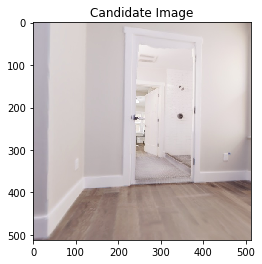

IndexError: index 20 is out of bounds for axis 0 with size 20

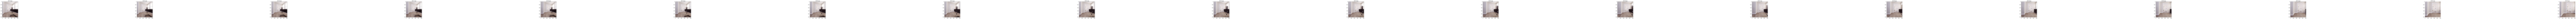

In [5]:
act_data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1636839314_sampled20_1114/1/default'
def_data_dir = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200_combined_2_sampled20_1115/1'

def get_candidates(data_dir):
    img_dir = os.path.join(data_dir, 'rgb')
    depth_dir = os.path.join(data_dir, 'depth')
    seg_dir = os.path.join(data_dir, 'seg')

    s = PickGoodCandidates(img_dir=img_dir, depth_dir=depth_dir, seg_dir=seg_dir)

    for gt in [5,10]:
    #     xs = s.sample_uniform_nn(gt)
        # pick gt frames for each instance 
        x2 = s.sample_uniform_nn2(gt)
        print(x2)
        for x in x2:
    #         print(x)
            s.vis(x)
        
# get_candidates(act_data_dir)
get_candidates(def_data_dir)

In [1]:
gtps = []
for gt in range(5, 15, 5):
    for p in range(0, 30, 5):
        gtps.append((gt,p))

print(len(gtps), gtps)

30 [(5, 0), (5, 5), (5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (15, 15), (15, 20), (15, 25), (20, 0), (20, 5), (20, 10), (20, 15), (20, 20), (20, 25), (25, 0), (25, 5), (25, 10), (25, 15), (25, 20), (25, 25)]


In [ ]:
[(5, 0), (5, 5),b(5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (15, 15), (15, 20), (15, 25), (20, 0), (20, 5), (20, 10), (20, 15), (20, 20), (20, 25), (25, 0), (25, 5), (25, 10), (25, 15), (25, 20), (25, 25)]

In [7]:
gtps = set()
for gt in range(5, 15, 5):
    for p in range(0, 30, 5):
        gtps.add((gt,p))

for gt in range(5, 30, 5):
    for p in range(0,15,5):
        gtps.add((gt,p))

gtps = sorted(list(gtps))
print(len(gtps), gtps)

21 [(5, 0), (5, 5), (5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (20, 0), (20, 5), (20, 10), (25, 0), (25, 5), (25, 10)]


In [6]:
for gt, p in gtps:
    print(gt, p)

25 5
10 15
15 5
5 5
15 0
20 0
5 25
25 0
5 0
10 0
15 10
20 10
5 15
20 5
25 10
10 5
5 10
10 10
10 25
5 20
10 20
